<a href="https://colab.research.google.com/github/Gayatridandgal/Road-Lane-line-detection/blob/main/roadlanelinedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Enter full file path (image or video): /content/r2.jpg
🖼️ Processing image: /content/r2.jpg
🔄 Resetting global line caches


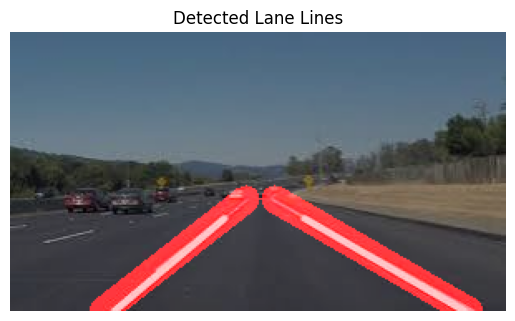

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import Video

# ====== GLOBAL CACHES FOR SMOOTHING ======
CACHE_LEFT_SLOPE = 0
CACHE_RIGHT_SLOPE = 0
CACHE_LEFT = [0, 0, 0]
CACHE_RIGHT = [0, 0, 0]

def reset_globals():
    global CACHE_LEFT_SLOPE, CACHE_RIGHT_SLOPE, CACHE_LEFT, CACHE_RIGHT
    print("🔄 Resetting global line caches")
    CACHE_LEFT_SLOPE = 0
    CACHE_RIGHT_SLOPE = 0
    CACHE_LEFT = [0, 0, 0]
    CACHE_RIGHT = [0, 0, 0]

def draw_lines(img, lines, color=[255, 0, 0], thickness=16):
    global CACHE_LEFT_SLOPE, CACHE_RIGHT_SLOPE, CACHE_LEFT, CACHE_RIGHT
    cache_weight = 0.9

    right_ys, right_xs, right_slopes = [], [], []
    left_ys, left_xs, left_slopes = [], [], []

    midpoint = img.shape[1] / 2
    bottom = img.shape[0]

    if lines is None:
        return

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope, _ = np.polyfit((x1, x2), (y1, y2), 1)
            if 0.35 < abs(slope) <= 0.85:
                if slope > 0 and x1 > midpoint and x2 > midpoint:
                    right_xs += [x1, x2]
                    right_ys += [y1, y2]
                    right_slopes.append(slope)
                elif slope < 0 and x1 < midpoint and x2 < midpoint:
                    left_xs += [x1, x2]
                    left_ys += [y1, y2]
                    left_slopes.append(slope)

    # Right lane line
    if right_ys:
        idx = right_ys.index(min(right_ys))
        x1, y1 = right_xs[idx], right_ys[idx]
        slope = np.median(right_slopes)
        if CACHE_RIGHT_SLOPE:
            slope += (CACHE_RIGHT_SLOPE - slope) * cache_weight
        x2 = int(x1 + (bottom - y1) / slope)
        if CACHE_RIGHT_SLOPE:
            x1 += int((CACHE_RIGHT[0] - x1) * cache_weight)
            y1 += int((CACHE_RIGHT[1] - y1) * cache_weight)
            x2 += int((CACHE_RIGHT[2] - x2) * cache_weight)
        CACHE_RIGHT_SLOPE = slope
        CACHE_RIGHT = [x1, y1, x2]
        cv2.line(img, (x1, y1), (x2, bottom), color, thickness)

    # Left lane line
    if left_ys:
        idx = left_ys.index(min(left_ys))
        x1, y1 = left_xs[idx], left_ys[idx]
        slope = np.median(left_slopes)
        if CACHE_LEFT_SLOPE:
            slope += (CACHE_LEFT_SLOPE - slope) * cache_weight
        x2 = int(x1 + (bottom - y1) / slope)
        if CACHE_LEFT_SLOPE:
            x1 += int((CACHE_LEFT[0] - x1) * cache_weight)
            y1 += int((CACHE_LEFT[1] - y1) * cache_weight)
            x2 += int((CACHE_LEFT[2] - x2) * cache_weight)
        CACHE_LEFT_SLOPE = slope
        CACHE_LEFT = [x1, y1, x2]
        cv2.line(img, (x1, y1), (x2, bottom), color, thickness)

def process_image(image):
    imshape = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    edges = cv2.Canny(blur, 25, 75)

    # Define ROI
    vertices = np.array([[
        (0, imshape[0]),
        (int(0.45 * imshape[1]), int(0.6 * imshape[0])),
        (int(0.55 * imshape[1]), int(0.6 * imshape[0])),
        (imshape[1], imshape[0])
    ]], dtype=np.int32)
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(edges, mask)

    # Hough Transform
    lines = cv2.HoughLinesP(masked, 1, np.pi/180, 10, minLineLength=30, maxLineGap=60)
    hough_img = np.zeros_like(image)
    draw_lines(hough_img, lines)

    return cv2.addWeighted(image, 0.8, hough_img, 1, 0)

# ========== PROCESS BASED ON FILE PATH ==========

file_path = input("📂 Enter full file path (image or video): ").strip()

if not os.path.exists(file_path):
    print("❌ File not found.")
else:
    ext = os.path.splitext(file_path)[-1].lower()

    if ext in ['.jpg', '.jpeg', '.png']:
        print(f"🖼️ Processing image: {file_path}")
        image = mpimg.imread(file_path)
        reset_globals()
        output = process_image(image)
        plt.imshow(output)
        plt.axis('off')
        plt.title("Detected Lane Lines")
        plt.show()

    elif ext in ['.mp4', '.avi', '.mov']:
        print(f"🎞️ Processing video: {file_path}")
        reset_globals()
        clip = VideoFileClip(file_path)
        output_path = f"output_{os.path.basename(file_path)}"
        processed_clip = clip.fl_image(process_image)
        processed_clip.write_videofile(output_path, audio=False)
        print(f"✅ Saved processed video to: {output_path}")
    else:
        print("❗ Unsupported file format. Please upload .jpg, .png, .mp4, etc.")
